# Intro
This notebook outlines the process of training various classifiers on the Wikipedia Talk dataset to classify comments into "safe" and "unsafe".

Included in this notebook are:
- initial exploration of the dataset
- several simple classifiers trained using `scikit-learn`.
- an evaluation of the classifiers across various metrics, in particular metrics designed for imbalanced datasets.

Included in the rest of the codebase is:
- `dataset_preparation.py`, a script to clean up and preprocess the dataset.
- `nn_classifier.py`, a script to train a custom deep learning classifier model based on the RoBERTa backbone.

Sadly the one major thing (currently) missing from this repo is a trained deep learning model: the training script works, I just lack the GPU access to train and tune a final model! This will hopefully be rectified soon.

## To read/use this notebook
You'll need to edit the paths in the first `Setup` cell below to reflect your own system. You may also need to install some libraries (e.g. `jax`, `langdetect`). Other than that, you can either look at the precomputed outputs or run them yourselves -- everything should (in theory!) be reproducible!

I've commented out the line that calls the deep learning training loop (in the `Third Classifier` section) just so it isn't run accidentally; feel free to uncomment and run it if you want!

## Libraries
- dataframes are handled with `polars`. `polars` is a significant improvement on `pandas`: it's faster, has better typing support, offers lazy evaluation out of the box, and is much closer in syntax to `pyspark` than `pandas` is. While either `polars` or `pandas` would work for the scale of the dataset we're considering here, `polars` will scale far better than `pandas` would.
- basic classifiers (Naive Bayes etc) are handled by `scikit-learn`. No reason to re-implement the wheel when `sklearn` has done it so well, and while it doesn't easily scale to datasets that don't fit in memory, at that point you probably should be using a more complicated model anyway.
- deep learning is handled by `JAX` and `Flax`. `JAX` is essentially numpy with autograd; it's Google's second attempt at writing a deep learning framework and incorporates a lot of what they learned from Tensorflow. It's functional, fast (thanks to just-in-time compilation), and has multi-GPU/TPU support built into it from the start. `Flax` is a library that builds on top of `JAX` and provides some object-oriented structure to abstract away some of the low-level grunt work of deep learning without getting in the way.

## Caveats
- The final classifier model in this notebook has not been particularly rigorously tuned: this is due to the fact that I don't have plentiful access to compute right now. Hopefully it is clear from the setup and code that a) a more rigorous hyperparameter search could easily be conducted, and b) I know how to do such a search if needed!
- With the RoBERTa-based model that I ended up with, yes it would have been far easier to simply import a model with a classifier head from HuggingFace and type `model.train`. However, given that the point of this exercise is to demonstrate that I understand what I'm doing with deep learning, I opted to go for the custom model / custom training loop approach.
  - The benefit of this approach is that it scales extremely well: I'm not restricted to the few classifier-head options that HuggingFace provides, and I can swap in a different foundation model with very little additional work.

## Possible Future Work
- Some simple but time consuming quality of life improvements:
  - integrate logging to replace the print statements
  - type hinting
  - reorganise some of the code: right now it's organised to match the format of this report, whereas in a production setting it would be organised differently (e.g. `nn_classifier.py` would be split into several smaller files!).

- More compute would unlock the following:
  - experimenting with different and larger foundation models to provide the embeddings (e.g. OPT).
  - much more rigorous hyperparameter tuning.

- More complex strategies to handle the annotation data:
  - e.g. [Dealing with Disagreements: Looking Beyond the Majority Vote in Subjective Annotations"](https://direct.mit.edu/tacl/article/doi/10.1162/tacl_a_00449/109286/Dealing-with-Disagreements-Looking-Beyond-the), Aida Mostafazadeh Davani et al.
  - Aggregating the annotations per sample in a more nuanced way; e.g. the original dataset paper tried averaging annotations per sample and using those as soft labels (that is, if 7/10 annotators identified the comment as unsafe, the target label became [0.7, 0.3]).

- More complex strategies to handle the data imbalance:
  - I used a very simple weighting strategy to handle the data imbalance in my model; another approach that I've seen work well in the past is to impose sampling quotas on each minibatch (that is, ensure each minibatch is balanced or close to balanced).
  - There are also synthetic data options, e.g. generating more samples using an LLM or using techniques such as [SMOTE](https://arxiv.org/abs/1106.1813).

- Evaluate the classifier for bias:
  - It's well known that classifiers in this field pick up biases from their data; specifically they will tend to disproportionately rate comments referencing marginalized groups as toxic/unsafe/attacks/etc unless this is actively mitigated against.
  - I would initially evaluate this using a dataset annotated for both identity demographics and toxicity, e.g. [CivilComments](https://www.tensorflow.org/datasets/catalog/civil_comments#civil_commentscivilcommentsidentities).
  - A more refined approach is to use counterfactual probing; that is, check whether the classifier tends to flip its label if you introduce or remove a reference to a marginalized group from the input. See my paper [Flexible text generation for counterfactual fairness probing](https://aclanthology.org/2022.woah-1.20/) for more details on this.

# Setup

In [ ]:
import os
import sys

home_dir = pathlib.Path(os.getenv('HOME'))

## edit these two paths as needed
path_to_library = '/home/zeef/git/wikitext-classifier'  # location of code
root_dir = home_dir.joinpath('temp', 'classifier')  # this is where data, models, etc will be stored

sys.path.append(path_to_library)

In [ ]:
import functools
import pathlib
import shutil

import polars as pl
import polars.selectors as cs
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import jax

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

import data_utils.utils as utils
from data_utils.dataset import TextDataset
from nn_classifier import create_roberta_classifier_from_hf

In [ ]:
source_data_dir = root_dir.joinpath('source_data')
data_dir = root_dir.joinpath('data')
model_dir = root_dir.joinpath('models')


In [ ]:
for x in [root_dir, data_dir, model_dir]:
  if not x.exists():
    x.mkdir()

# Dataset exploration

## Download the data
First step: get the data! I've written a quick function using the `requests` library to handle this.

For reference, [here](https://arxiv.org/pdf/1610.08914) is the paper associated to the dataset.

In [ ]:
# make sure we're getting a clean copy of the data
if source_data_dir.exists():
  shutil.rmtree(source_data_dir)
source_data_dir.mkdir()

source_data_files = utils.get_wikipedia_talk_data(source_data_dir)

dataframes = {}
for x in source_data_files:
  dataframes[x] = pl.read_csv(source_data_files[x])

print(dataframes)

## Explore the comments dataset

In [ ]:
df = dataframes['comments']
df.head()

rev_id,comment,year,logged_in,ns,sample,split
i64,str,i64,bool,str,str,str
37675,"""`-NEWLINE_TOKENThis is not ``c…",2002,false,"""article""","""random""","""train"""
44816,"""`NEWLINE_TOKENNEWLINE_TOKEN:: …",2002,false,"""article""","""random""","""train"""
49851,"""NEWLINE_TOKENNEWLINE_TOKENTrue…",2002,false,"""article""","""random""","""train"""
89320,""" Next, maybe you could work on…",2002,true,"""article""","""random""","""dev"""
93890,"""This page will need disambigua…",2002,true,"""article""","""random""","""train"""


According to the paper, we have:
- `rev_id`: for joining the comments with the annotations.
- `comment`: the raw text of the comment; very little has been done to it so far apart from replacing `\n` with `NEWLINE_TOKEN`, `\t` with `TAB_TOKEN`, and `"` with ``.
- `year`: the year the comment was posted.
- `logged_in`: whether the comment poster was logged in when they made the comment.
- `ns`: namespace, `article` or `user`. This tells us whether the comment was left on on an article or a user discussion page.
- `sample`: `random` or `blocked`. The authors constructed the dataset by taking a random sample of comments but noted that the overall prevalance of attacking comments is around 1%, so in order to increase the number of toxic comments they sampled additional comments from users who had been blocked by moderators for violating Wikipedia's policies on personal attacks.
- `split`: the authors have kindly already created a train/dev/test split for us.

Before using the provided splits, let's doublecheck that they all have reasonably similar distributions:

In [ ]:
split = 'train'  # replace this with 'dev' or 'test' to see the other splits

df_temp = df.filter(pl.col('split') == split)
for col in ['year', 'logged_in', 'ns', 'sample']:
  print(col)
  with pl.Config(tbl_rows = 20):
    print(df_temp.select(pl.col(col).value_counts()).unnest(col).with_columns(pl.col('count')/len(df_temp)))

year
shape: (16, 2)
┌──────┬──────────┐
│ year ┆ count    │
│ ---  ┆ ---      │
│ i64  ┆ f64      │
╞══════╪══════════╡
│ 2008 ┆ 0.144119 │
│ 2010 ┆ 0.093318 │
│ 2013 ┆ 0.055102 │
│ 2005 ┆ 0.04184  │
│ 2012 ┆ 0.065774 │
│ 2001 ┆ 0.000086 │
│ 2009 ┆ 0.10783  │
│ 2014 ┆ 0.056727 │
│ 2006 ┆ 0.150965 │
│ 2015 ┆ 0.058712 │
│ 2016 ┆ 0.002646 │
│ 2007 ┆ 0.140926 │
│ 2002 ┆ 0.000388 │
│ 2011 ┆ 0.074979 │
│ 2003 ┆ 0.00128  │
│ 2004 ┆ 0.005307 │
└──────┴──────────┘
logged_in
shape: (2, 2)
┌───────────┬──────────┐
│ logged_in ┆ count    │
│ ---       ┆ ---      │
│ bool      ┆ f64      │
╞═══════════╪══════════╡
│ false     ┆ 0.268676 │
│ true      ┆ 0.731324 │
└───────────┴──────────┘
ns
shape: (2, 2)
┌─────────┬──────────┐
│ ns      ┆ count    │
│ ---     ┆ ---      │
│ str     ┆ f64      │
╞═════════╪══════════╡
│ article ┆ 0.449558 │
│ user    ┆ 0.550442 │
└─────────┴──────────┘
sample
shape: (2, 2)
┌─────────┬──────────┐
│ sample  ┆ count    │
│ ---     ┆ ---      │
│ str     ┆ f64      │
╞═

Looks like they did a pretty good job! We'll check again once the annotations have been added to make sure the safe/unsafe split is also consistent.

Next, let's have a look at the comment lengths:

In [ ]:
df_temp = df.with_columns(pl.col('comment').str.len_chars().alias('comment_length'))
comment_length = df_temp.select(pl.col('comment_length'))
comment_length.describe()

statistic,comment_length
str,f64
"""count""",115864.0
"""null_count""",0.0
"""mean""",460.58415
"""std""",812.572108
"""min""",21.0
"""25%""",122.0
"""50%""",238.0
"""75%""",478.0
"""max""",18460.0


<Axes: ylabel='Count'>

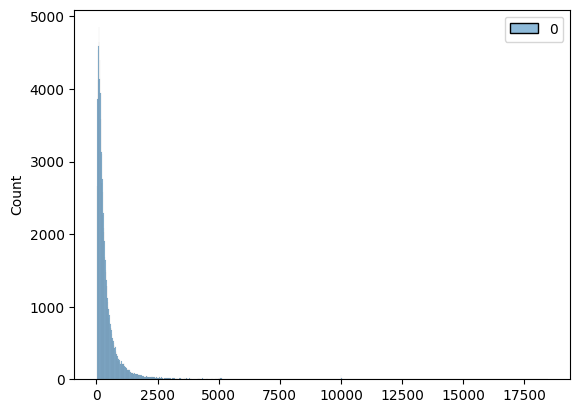

In [ ]:
sns.histplot(data=comment_length)

The vast majority of the comments come in at 2500 characters or less (even before cleaning!) but there are outliers all the way up to 18k or so.

It will probably be worth dropping the really really long comments from the training set: too much risk of losing the signal within the noise: if a mostly-innocuous essay-length comment has one personal attack in it, the entire thing would be labelled as "attack".

Another reason for dropping long comments from the train set is that when we get to the point of using a foundation model to create embeddings, many of these models have a max input length. Truncating long comments risks cutting off any attacking language from the portion of the comment that the model sees, and we don't have sufficiently fine-grained annotations to chunk the comments.

However, we will still need to handle long comments during inference! This is easier: we can chunk the comments, run inference on each chunk, and then combine the predictions somehow (e.g. averaging or majority vote). It's only during training that we would need ground truth labels for each chunk.

## Explore the annotations dataset

In [ ]:
df = dataframes['annotations']
df.head()

rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
i64,i64,f64,f64,f64,f64,f64
37675,1362,0.0,0.0,0.0,0.0,0.0
37675,2408,0.0,0.0,0.0,0.0,0.0
37675,1493,0.0,0.0,0.0,0.0,0.0
37675,1439,0.0,0.0,0.0,0.0,0.0
37675,170,0.0,0.0,0.0,0.0,0.0


According to the dataset paper, each sample was separately annotated by approximately 10 people, and classified into sub-types such as `recipient_attack` (directly attacking the person the comment is addressed to) or `third_party_attack` (attacking someone else).

For our purposes, we only need to categorise the comments into `unsafe` or `safe`, which correspond to "contains an attack" and "doesn't contain an attack" respectively.

We can doublecheck that the `attack` column has already done this consolidation for us:

In [ ]:
# this expression just checks each row and compares whether the cells ending with '_attack'
# have at least one 1.0 in them if and only if the 'attack' cell has a 1.0
attack_comparison = (df.select(cs.ends_with('_attack')).sum_horizontal().alias('attack') > 0.0).cast(pl.Float64).to_frame() == df.select(pl.col('attack'))

# If the 'attack' column is indeed a correct aggregation of the attack subtypes, then
# the sum of 'attack_comparison' should equal the length of the dataframe.
len(df) == attack_comparison.select(pl.col('attack').sum()).item()

True

In other words, we can ignore all of the columns apart from `rev_id` (for joining to the comments dataframe) and `attack`, which is essentially our label column.

A deeper analysis could also make use of the `worker_id` column -- the dataset also provides demographics and stats on each annotator, and there has been some interesting research (see intro) on whether we can use this information to identify "reliable" annotators. These annotators were sourced on Amazon MTurk, which is notoriously unreliable as an annotation source these days, but this deeper analysis is out of scope for this initial exploration.

# Dataset cleanup and preprocessing

Based on the above, we can make some preliminary decisions:

- Tempting though it is to use the additional features in the `comments` dataframe (e.g. `ns` would probably be a pretty good signal for identifying toxic comments!), this would produce a classifier that could not generalise to non-Wikipedia sources. For the purposes of creating a general-use classifier, we'll stick to just using the text of the comment itself.
- We should filter out very long comments: initially I've set the limit to 6000 characters, which retains 99.6% of the comments. (We'll revisit this later once we have a tokenizer.)

In [ ]:
df_temp = dataframes['comments'].with_columns(pl.col('comment').str.len_chars().alias('comment_length'))
len(df_temp.filter(pl.col('comment_length') <= 6000)) / len(df_temp)

0.995788165435338

- We should also filter out non-English comments. I haven't displayed that in this notebook because running `langdetect` over the entire dataset is pretty slow, but we lose approximately 3000 comments by filtering out anything that `langdetect` identifies as not English.
- In terms of preprocessing, there are some obvious choices:
  - lowercase everything
  - strip out the NEWLINE_TOKENs and TAB_TOKENs
  - use a normalization function to replace accented characters to their corresponding non-accented character (this is helpfully built into `scikit-learn`'s text vectorizers)
  - strip out punctuation, numbers, and non-standard characters (this is why we stripped out the accented characters first!).
- We need some way of consolidating the multiple annotations per sample into one overall label. I've implemented two basic approaches, namely:
  - majority vote, breaking ties in favour of the `safe` label.
  - binarized average (that is, take the average of the labels and round up everything above some fixed threshold to 1, round everything else down to 0).

I've consolidated all of the above into the script `dataset_preparation.py`; please see that file for details! If you want to run it yourself, you may need to edit `config/data_prep.yaml` so that the root directory points to the right place on your system.

Note this cell will take several minutes to run, primarily due to running `langdetect`. You'll see progress updates printed out as it runs.

In [ ]:
!python dataset_preparation.py

Processing train split of wikipedia_talk; size 69526
Finished processing train split of wikipedia_talk; size 67660
Processing dev split of wikipedia_talk; size 23160
Finished processing dev split of wikipedia_talk; size 22500
Processing test split of wikipedia_talk; size 23178
Finished processing test split of wikipedia_talk; size 22591


## Checking the label distribution per split

Finally, as promised, let's check what the label distribution looks like in each split. For simplicity I've stuck with the "majority vote" approach to aggregating annotations.

In [ ]:
datasets = {x.stem.split('_')[0]: pl.read_csv(x) for x in data_dir.glob('*withlabels*')}

In [ ]:
for k, df in datasets.items():
  print(k)
  print(df.group_by(pl.col('attack'), maintain_order=True).len().select([pl.col('attack').alias('label'), (pl.col('len')/len(df)).alias('fraction')]))

train
shape: (2, 2)
┌───────┬──────────┐
│ label ┆ fraction │
│ ---   ┆ ---      │
│ i64   ┆ f64      │
╞═══════╪══════════╡
│ 0     ┆ 0.888546 │
│ 1     ┆ 0.111454 │
└───────┴──────────┘
dev
shape: (2, 2)
┌───────┬──────────┐
│ label ┆ fraction │
│ ---   ┆ ---      │
│ i64   ┆ f64      │
╞═══════╪══════════╡
│ 0     ┆ 0.886622 │
│ 1     ┆ 0.113378 │
└───────┴──────────┘
test
shape: (2, 2)
┌───────┬──────────┐
│ label ┆ fraction │
│ ---   ┆ ---      │
│ i64   ┆ f64      │
╞═══════╪══════════╡
│ 0     ┆ 0.886503 │
│ 1     ┆ 0.113497 │
└───────┴──────────┘


From this we can see two things:
1. The splits each have almost identical label distributions, so we can just use the splits as-given.
2. The data is still wildly imbalanced despite the authors' best attempts (in fairness, they got the `unsafe` class from 0.01 to 0.11, not bad!) so we'll have to remember:
  - We should evaluate our classifiers using metrics designed for imbalanced datasets.
  - A classifier that gets 88% accuracy is performing at random chance levels.

# Baseline classifier: Naive Bayes

We're trying to apply binary classification to a text dataset: the obvious baseline classifier is a Naive Bayes one.

Let's go as simple as possible:
- word-based tokenization
- vectorize samples using `sklearn`'s `CountVectorizer`, i.e. just count how many occurrences of each word appears in the sample.
- `sklearn`'s `ComplementNB` Naive Bayes classifier, since it is particularly well suited for imbalanced datasets.

In [ ]:
df_train = datasets['train']
df_eval = datasets['dev']

In [ ]:
pipeline1 = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("clf", ComplementNB()),
    ]
)

# utils.df_col_to_list is a simple helper function I wrote to extract a column from a dataframe
# and convert it to a list, since I ended up needing to do it a lot for these sklearn classifiers!

# training this classifier is as simple as calling pipeline.fit
pipeline1 = pipeline1.fit(utils.df_col_to_list(df_train, 'comment_processed'), utils.df_col_to_list(df_train, 'attack'))

# and scoring it is as simple as calling pipeline.score
# note that this just returns the basic unweighted accuracy; we'll come back to this later!
pipeline1.score(utils.df_col_to_list(df_eval, 'comment_processed'), utils.df_col_to_list(df_eval, 'attack'))

0.9065777777777778

We can see that on a simple accuracy metric, this classifier is only just doing better than random chance. Unweighted accuracy is obviously not a great choice of metric here due to the imbalanced dataset, and we'll look at other metrics later, but as a coarse first-pass "is this model working?" metric it's not bad.

Let's try making it a bit more interesting, by introducing a tf-idf vectorizer and considering 2-grams in addition to 1-grams:

In [ ]:
pipeline2 = Pipeline(
    [
        ("vect", TfidfVectorizer(ngram_range=(1, 2))),
        ("clf", ComplementNB()),
    ]
)

pipeline2 = pipeline2.fit(utils.df_col_to_list(df_train, 'comment_processed'), utils.df_col_to_list(df_train, 'attack'))
pipeline2.score(utils.df_col_to_list(df_eval, 'comment_processed'), utils.df_col_to_list(df_eval, 'attack'))

0.9061777777777777

Not much better! Let's see how it's doing on each label type:

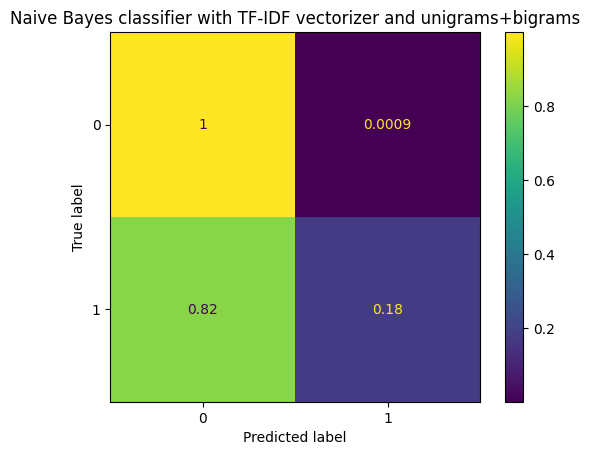

In [ ]:
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_estimator(pipeline2, utils.df_col_to_list(df_eval, 'comment_processed'), utils.df_col_to_list(df_eval, 'attack'), normalize='true', ax=ax)
ax.set_title('Naive Bayes classifier with TF-IDF vectorizer and unigrams+bigrams')
plt.show()

Yep, so what we've built there is a classifier that predicts "safe" for almost everything, and the 90%+ accuracy comes from the fact that 88.5% of the dataset is indeed labelled "safe".

There's a lot more we could try here, e.g.
  - stemming or lemmatizing the words (essentially standardizing them, so e.g. "run", "runs", "running" would all be treated as the same word).
  - more tuning of the various hyperparameters.
  - introduce a stopwords list to remove common words (this is discussed in more detail just below)

However I think it's pretty clear that Naive Bayes isn't going to cut it here, so let's move on to the next option.

We'll evaluate all of the classifiers more thoroughly with more detailed metrics at the end.

# Second classifier: logistic regression

The next simplest option is logistic regression.

We'll stick with the tf-idf vectorization, because it's better at handling common words than a simple counting-based vectorization is. That is to say, the "idf" portion of "tf-idf" stands for "inverse document frequency", and it penalises extremely common words like "and", "the", etc by downweighting them. This makes sense, as both safe and unsafe comments are equally likely to use these sorts of words so from the classifier's perspective they're just noise!

In [ ]:
# First attempt: simple logistic regression with L2 regularization

pipeline3 = Pipeline(
    [
        ("vect", TfidfVectorizer(ngram_range=(1, 2))),
        ("clf", LogisticRegression(penalty='l2')),
    ]
)

pipeline3 = pipeline3.fit(utils.df_col_to_list(df_train, 'comment_processed'), utils.df_col_to_list(df_train, 'attack'))
pipeline3.score(utils.df_col_to_list(df_eval, 'comment_processed'), utils.df_col_to_list(df_eval, 'attack'))

0.9385333333333333

That's an improvement!

Now let's get fancy: we'll use sklearn's built-in class_weight option to upweight the positive samples, see if that helps mitigate the imbalance. We could specify the weights manually, but the 'balanced' keyword simply weights class labels in inverse proportion to their prevalance and that's a pretty good first strategy to try.

In [ ]:
# Regression with weighted samples
pipeline4 = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("clf", LogisticRegression(penalty='l2', class_weight='balanced')),
    ]
)

pipeline4 = pipeline4.fit(utils.df_col_to_list(df_train, 'comment_processed'), utils.df_col_to_list(df_train, 'attack'))
pipeline4.score(utils.df_col_to_list(df_eval, 'comment_processed'), utils.df_col_to_list(df_eval, 'attack'))

0.9228888888888889

Interesting! Let's plot the confusion matrices to see if balancing the class weights had any effect:

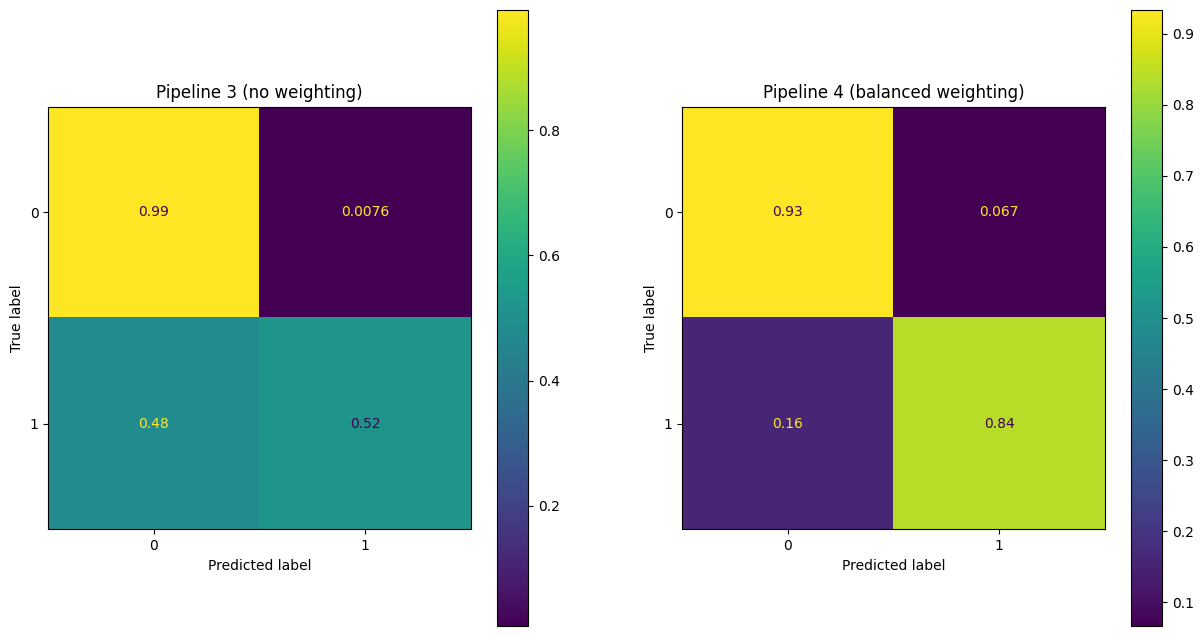

In [ ]:

fig, axes = plt.subplots(ncols=2, figsize=(15,8))
ConfusionMatrixDisplay.from_estimator(pipeline3, utils.df_col_to_list(df_eval, 'comment_processed'), utils.df_col_to_list(df_eval, 'attack'), normalize='true', ax=axes[0])
axes[0].set_title('Pipeline 3 (no weighting)')

ConfusionMatrixDisplay.from_estimator(pipeline4, utils.df_col_to_list(df_eval, 'comment_processed'), utils.df_col_to_list(df_eval, 'attack'), normalize='true', ax=axes[1])
axes[1].set_title('Pipeline 4 (balanced weighting)')


plt.show()

That's a huge improvement in true positives for the unsafe class, at the cost of a drop in performance on the safe class.

We can also compare this to the NB classifier: we've gone from 18% of the "unsafe" class being predicted correctly by the NB classifier to 52% on the basic LR classifier, but our overall accuracy only went up by a couple of points! This is a good illustration of why unweighted accuracy should be taken with a large grain of salt on unbalanced datasets.

We could continue to play around with tuning the hyperparameters for this (e.g. l1 regression instead of / as well as l2, changing the regularization strength constant `C`, etc; also using `sklearn`'s built-in hyperparameter search and cross validation functions!) but in a world of Transformers, attention, and LLMs I think it's a safe bet that we'll see better results from a Transformer-based embedding than a "traditional" ML one.

This is partly because Transformers have consistently outperformed other models on basically every text-based task, but also because their attention mechanism allows them to take the _context_ of words into account. Consider the difference between these two sentences:
- "haha I'm such an idiot"
- "you're an idiot and you're wrong".

A simple classifier might learn that "idiot" corresponds to an attack and label both as unsafe, whereas a Transformer-based model is much more likely to identify that the word "idiot" is being used in very different contexts in the two sentences.

# Third classifier: RoBERTa-based neural net

As described in the introduction, this is a custom model with a custom training loop, written in JAX/Flax and layering a dense classifier head over a frozen pretrained RoBERTa model.

- Why RoBERTa?
  - On previous projects I've worked on, we found that RoBERTa provided a good balance between speed and accuracy.
  - I considered newer models like OPT but felt they might be overkill for what we need here (we're just using the Transformer model to get embeddings), especially since I don't have the access to plentiful compute that would be required to iterate on such large models. It would be very easy to test this in future though!
  - BERT would probably also work well, but RoBERTa is literally just BERT with a few extra bells and whistles to make it more robust.

- Why a frozen RoBERTa?
  - Compute limitations! As a proof of concept, I went for the simplest option that would work.
  - The code is written in such a way to make it very easy to modify which layers are trainable: one could easily finetune the last few layers of RoBERTa in addition to the classifier, or even finetune the entire thing end-to-end.

- Why JAX/Flax?
  - JAX/Flax is a lovely combination of libraries to work in. They're fast, optimized for multi-GPU and even TPU settings, and the clear separation between model definition and parameters makes it much easier to keep track of what's happening when freezing part of the model and adding in extra layers.

The training loop also uses:
- a custom TextDataset object subclassed from PyTorch's `torch.utils.data.Dataset`, and a vanilla `torch.utils.data.DataLoader`. This is because JAX/Flax considers dataset handling to be out of scope and expects users to use tensorflow, torch, or huggingface dataset utilities instead.
  - I personally despise Tensorflow's dataset and data iterator implementations, because the underlying implementation stores the data in a sequential format which makes it impossible to index into the dataset, you can _only_ iterate through it. This also makes reproducibility a nightmare, because if your training loop crashes and is resumed from the last saved checkpoint, the dataset iterator will always start from the beginning of the dataset again! In a worst case scenario you can end up only ever training on a small portion of your dataset!
  - I find HuggingFace's API really annoying to use if I'm doing anything remotely custom: it's too high level and hides too much.
  - Thus, PyTorch is the only usable option here.
- HuggingFace's implementation of vanilla RoBERTa, the pretrained weights provided by FacebookAI, and HuggingFace's tokenizer.
  - In a production environment, I would fork HuggingFace's RoBERTa implementation and remove the dependency on their `transformers` library altogether. That felt like overkill for a 1-week project, however!

## Training/eval code
You can find the training and eval code in `nn_classifier.py`.

The construction of the training loop follows JAX/Flax conventions: that is, one writes minimal `train_step` and `eval_step` functions that can be jit-compiled for speed, wraps them in larger `train` and `evaluation` functions that handle dataset iteration, and keeps track of parameters and other stateful objects in a dedicated object called `TrainState`.

Software engineering caveat: I put all of the code for the training loop in one file mostly to make it easier to follow for people who aren't familiar with JAX or with deep learning training loops. As soon as multiple models were involved, I would refactor this into a more modular arrangement!

In [ ]:
# I don't recommend running this cell unless you have access to a GPU.
# If you do, make sure you modify `config/train.yaml` so that the script
# knows where to find the processed datasets.

# If you're sure, you can uncomment the line below and run this cell to
# kick off the training run.

# !python nn_classifier.py

## A note on tokenization

As discussed briefly in the dataset exploration section, one thing we have to take into account when working with a language model is the size of the context window -- that is, how many tokens it can accept at one time.

This is relevant here because our dataset is only labelled at the sample level (i.e. one safe/unsafe label per item) and if we chunk long comments into multiple samples or even just naively truncate our samples, we risk cutting off the toxic portion of a comment and introducing mislabelled samples into the training set. In a balanced dataset this might not matter, but since the unsafe samples are already underrepresented, introducing some false positives could have a much larger effect on overall performance.

RoBERTa's context window is 512 tokens long, and it uses the BPE tokenization scheme which means that tokens correspond to subwords. In other words, there should be a fairly linear relationship between word/character count and token count, but we don't have a direct conversion between words and tokens.

To solve this, we can tokenize a subset of the dataset and plot the token length of each sample against the character count, and use this to establish a reasonable cutoff.

In [ ]:
# import the pretrained RoBERTa tokenizer

config = {'params_key': jax.random.PRNGKey(0), 'backbone_hf_str': "FacebookAI/roberta-base", 'classifier_head_dims': (2,),}

clf = create_roberta_classifier_from_hf(config)
tokenizer = clf['tokenizer']

In [ ]:
# quickly test the tokenizer

test_sentence = "Here is a random sentence about cats."
tokenizer(test_sentence, padding='longest', truncation=True, max_length=1000)

{'input_ids': Array([[    0, 11773,    16,    10,  9624,  3645,    59, 10017,     4,
            2]], dtype=int32), 'attention_mask': Array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)}

In [ ]:
tokenizer(test_sentence, padding='longest', truncation=True, max_length=1000)['attention_mask'].sum().item()

10

In [ ]:
# using the dev dataset to establish the linear relationship
# summing the attention mask gives us the number of tokens
# this is a terribly slow way to use polars (any call to a python function breaks its multithreading) but it'll do for this ad-hoc calculation

tokenizer1 = functools.partial(tokenizer, padding='longest', truncation=True, max_length=1000)
df_eval = df_eval.with_columns(pl.col('comment_processed').map_elements(lambda x: tokenizer1(x)['attention_mask'].sum().item(), return_dtype=pl.Int32).alias('token_length'))

In [ ]:
df_eval.select(pl.col('token_length')).describe()

statistic,token_length
str,f64
"""count""",22500.0
"""null_count""",0.0
"""mean""",77.508444
"""std""",106.128488
"""min""",4.0
"""25%""",22.0
"""50%""",44.0
"""75%""",88.0
"""max""",1000.0


We capped the token length at 1000 for simplicity, but we can see from this that the vast majority fall below 100 tokens.

Now we can plot this on a scatterplot to get a sense for the relationship.

As we'll see below, something like a kdeplot should be a better choice here because the vast majority of the density is concentrated in the lower left quadrant; however it turns out it's _so_ concentrated that the kdeplot ignores the outliers completely. And since we were doing this to get a sense for where the outliers landed, that's not so useful right now.

So here is a scatterplot, and just keep in mind that the density is wildly misrepresented:

In [ ]:
# We should get the length of the processed comments, not the raw comments, since it's the processed comments we tokenized
df_eval = df_eval.with_columns(pl.col('comment_processed').str.len_chars().alias('comment_processed_char_count'))

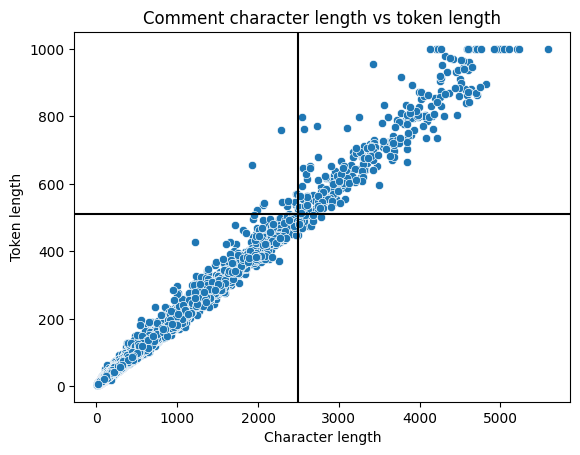

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(x = utils.df_col_to_list(df_eval, 'comment_processed_char_count'), y = utils.df_col_to_list(df_eval, 'token_length'), ax=ax)
# sns.kdeplot(x = utils.df_col_to_list(df_eval, 'comment_processed_char_count'), y = utils.df_col_to_list(df_eval, 'token_length'), ax=ax, alpha=0.5, fill=True, levels=10)
ax.axhline(y=512, c='k')
ax.axvline(x=2500, c='k')
ax.set_title('Comment character length vs token length')
ax.set_xlabel('Character length')
ax.set_ylabel('Token length')
plt.show()

The horizontal line corresponds to the 512 token cutoff. If we choose a character length cutoff of 2500 characters (the vertical line) then
- datapoints in the lower left quadrant will be handled without issue.
- datapoints in the upper left quadrant will be truncated.
- datapoints on the right halfplane will be discarded.

The graph makes it look like we're losing a lot of data here, but it isn't accurately representing the density in the lower left quadrant:

In [ ]:
lh = len(df_eval.filter(pl.col('comment_char_count')<=2500))
rh = len(df_eval.filter(pl.col('comment_char_count')>2500))

print(f"There are {lh} comments in the left halfplane")
print(f"There are {rh} comments in the right halfplane")
print(f"We can expect to lose approximately {rh/len(df_eval):.2%} of comments if we discard comments longer than 2500 characters.")

There are 22109 comments in the left halfplane
There are 391 comments in the right halfplane
We can expect to lose approximately 1.74% of comments if we discard comments longer than 2500 characters.


Conclusion: 2500 characters seems like a reasonable cutoff!

## Inference

Finally, let's load a saved model and play around with some inference.

In [ ]:
## TODO

# Evaluation

We will compare three models:
- Naive Bayes (`pipeline1`)
- Logistic regression (`pipeline4`)
- RoBERTa-based neural net

We saw above that a simple accuracy score isn't very useful on an imbalanced dataset. Instead, let's look at:
- weighted accuracy
- precision, recall, F1
- ROC-AUC

For weighted accuracy, we'll use `sklearn`'s `balanced_accuracy_score`, which computes the average of recall scores across each class and is equivalent to weighting each class by its inverse frequency. (This is the definition of weighting we used in training the RoBERTa classifier too.)

The original dataset paper also trained various classifiers to achieve this task. For reference, their best model achieved an AUC score of 96.59, although with the caveat that this was computed on the `dev` split, not the `test` split as we're computing here.

In [ ]:
# this is the test split of the original dataset; it has been processed using the
# same techniques as the others, but we have not examined it and our models have
# not seen it yet.

df_test = datasets['test']

In [ ]:
inputs = utils.df_col_to_list(df_test, 'comment_processed')
labels = utils.df_col_to_list(df_test, 'attack')

In [ ]:
## TODO: add in the RoBERTa model once it is trained

models = {'naive_bayes': pipeline1, 'regression': pipeline4}
metrics = {
    "accuracy": accuracy_score,
    "weighted_accuracy": balanced_accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1": f1_score,
    "roc_auc": roc_auc_score,
}


all_scores = []
for m in models:
  result = {'model': m}
  for n in metrics:
    if n == 'roc_auc':
      preds = models[m].predict_proba(inputs)[:, -1]  # expects the probs for the class with the larger label
    else:
      preds = models[m].predict(inputs)
    score = metrics[n](labels, preds)
    result[n] = score
  all_scores.append(result)

In [ ]:
pl.DataFrame(all_scores)

model,accuracy,weighted_accuracy,precision,recall,f1,roc_auc
str,f64,f64,f64,f64,f64,f64
"""naive_bayes""",0.908548,0.831771,0.576427,0.732449,0.645139,0.884869
"""regression""",0.926254,0.877126,0.637141,0.813573,0.714628,0.95798


##  Definitions

- Weighted accuracy:
  - This weights the positive and negative classes by the inverse proportion of their frequency in the dataset. That is, in this setting it downweights the contribution of the negative examples to the overall accuracy score, to cancel out the fact that there is so many more of them than the positive examples.
- Precision:
  - Precision is, informally, the proportion of relevant instances amongst the examples that the model predicted to be positive: that is, if the regression model identified 100 examples that it thought were positive (i.e. unsafe), you'd expect approximately 64 of them to be actually unsafe and the rest to be false positives.
  - You would value precision over recall if you were particularly concerned about false positives, i.e. needed to be pretty sure that the model would rarely label a safe example as unsafe.
  - The precision score depends on the ratio of positive/negative classes in the dataset, so it is unsurprising that the precision is so low here when the classes are unbalanced.
- Recall:
  - Recall, is, informally, the proportion of positive instances that were correctly predicted: that is, if you gave the regression model 100 "unsafe" examples, you'd expect it to accurately label approximately 81 of them.
  - You would value recall over precision if you were particularly concerned about false negatives, i.e. needed to be sure that the model would rarely mislabel an unsafe example as safe.
  - Recall does not depend explicitly on the positive/negative class imbalance, because the denominator is just the number of samples in the positive class. However, bear in mind that this means the recall is computed using only a small subset of the dataset in this case!
- F1 score:
  - This is the harmonic mean of precision and recall. It's a useful way of consolidating both precision and recall into one balanced number.
- ROC-AUC:
  - Informally, the ROC-AUC represents the probability that, given a positive example and a negative example, the model will rank the positive example higher than the negative example.
  - That is, if you gave the regression model a positive example and a negative example, there's a 95.7% chance that it'll give the positive (unsafe) example a higher score than the negative (safe) example.

## Conclusions

We can immediately see that:
- Regression performed better than Naive Bayes on literally every measure.
- Our fairly untuned regression model hit 0.958 on AUC, which is really not far from the original paper's 0.966!
- Unweighted accuracy is hiding the lower performance on the positive class in both cases; I've included it here just for comparison.
- Neither of these classifiers are remotely ready for deployment: precision and recall are both pretty low, which means we're seeing lots of false positives and false negatives, and the weighted accuracy of the regression classifier is still only 87%: not great!
- The AUC score of the regression classifier isn't bad: it can at least say "this example is probably more unsafe than that one" pretty reliably, so it has learned _something_ from the dataset. It just hasn't learned a uniform threshold yet.


